# Calculus of Variations Example
## Shortest path to a curve from origin

In [4]:
from os.path import exists
file_exists = exists('basic_material.py')

if (not file_exists):
    !wget -O basic_material.py https://www.dropbox.com/s/o48uhuwah8n2xww/basic_material.py?dl=0
%run basic_material

try:
    %reload_ext autoreload
except:
    %load_ext autoreload
%autoreload 2

try:
    from pyomo.environ import *
except:
    %pip install pyomo
from pyomo.environ import *
from pyomo.dae import *

# check if ipopt is installed. If not, install.
if not (shutil.which("ipopt") or os.path.isfile("ipopt")):
    if "google.colab" in sys.modules:
        !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
        !unzip -o -q ipopt-linux64
    else:
        try:
            !conda install -c conda-forge ipopt 
        except:
            pass
assert(shutil.which("ipopt") or os.path.isfile("ipopt"))

from pyomo.environ import *
from pyomo.dae import *

Running Python: 3.8.12


In [5]:
def my_solve(t_off=5,y_off=1): # create a model object
    m = ConcreteModel()
    # define the independent variable
    m.tf = Var(domain=NonNegativeReals)
    m.t = ContinuousSet(bounds=(0,1))

    # define the dependent variables
    m.y = Var(m.t)
    # define derivatives
    m.y_dot = DerivativeVar(m.y, wrt=m.t)
    m.J = Var(m.t)
    m.J_dot = DerivativeVar(m.J, wrt=m.t)
    # define the optimization objective
    m.ode_J = Constraint(m.t, rule=lambda m, t: m.J_dot[t] == m.tf*sqrt(1 + (m.y_dot[t]/m.tf)**2))
    m.obj = Objective(expr=m.J[1], sense=minimize)

    # initial conditions
    m.pc = ConstraintList()
    m.pc.add(m.y[0]==0)
    m.pc.add(m.J[0]==0)
    # final conditions
    def _con(m, t):
          return m.y[1]==0.5*((m.tf-t_off)**2-y_off)
    m.con = Constraint(m.t, rule=_con)

    # transform and solve
    TransformationFactory('dae.finite_difference').apply_to(m, wrt=m.t, nfe=300)
    solver = SolverFactory('ipopt')
    solver.options['max_iter']= 10000 #number of iterations you wish
    solver.solve(m)#.write()
    return m

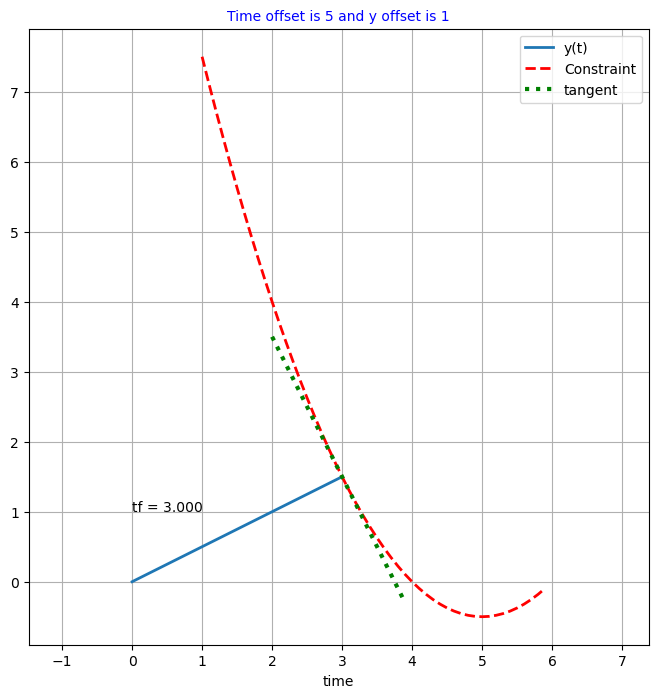

In [7]:
t_off = 5 # offset of the constraint
y_off = 1 # offset of constraint

m = my_solve(t_off,y_off)

# access the results
tt = np.array([t*m.tf() for t in m.t])
y = np.array([m.y[t]() for t in m.t])
yd = np.array([m.y_dot[t]() for t in m.t])

tf = tt[-1]
yf = y[-1]
jtime=np.arange(tf-2,t_off+1,.1)
jtime2=np.arange(tf-1,tf+1,.1)
slope = (tf-t_off)

plt.figure(figsize=(8,8))
plt.plot(tt, y, ls='-',label='y(t)')
plt.plot(jtime, 0.5*((jtime-t_off)**2-y_off), 'r--',label='Constraint')
plt.plot(jtime2, slope*(jtime2-tf)+yf, 'g:',label='tangent',lw=3)
plt.xlabel('time')
plt.ylim([min(y), max(y)])
plt.axis('Equal')
plt.legend()
plt.text(0,min(y)+1,str(f'tf = {tf:.3f}'))
plt.title('Time offset is '+str(t_off)+' and y offset is '+str(y_off))
plt.savefig('./figs/CoV_example1.png')
plt.grid(True)

The solution is tangent to the contraint at the point of contact, as evident by the orthogonality of the solution to the constraint tangent line.